# Aprendizaje Supervisado

## Sección 1: Introducción teórica

#### Aprendizaje Supervisado:
Es un tipo de algoritmo de machine learning donde el modelo aprende a partir de datos etiquetados. Esto significa que el modelo recibe entradas junto con las salidas deseadas, lo que le permite hacer predicciones o clasificaciones sobre nuevos datos no vistos. Algunos algoritmos comunes en PySpark incluyen:
- DecisionTreeClassifier
- RandomForestClassifier
- GBTClassifier
- MultilayerPerceptronClassifier

#### Aprendizaje No Supervisado:
En este enfoque, los datos no están etiquetados. El modelo intenta encontrar patrones, relaciones o estructuras en los datos por sí mismo. Los algoritmos típicos de aprendizaje no supervisado incluyen:
- KMeans
- GaussianMixture
- PowerIterationClustering (PIC)

## Sección 2: Selección de los datos


In [38]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder.appName("MuestreoSeguridad").getOrCreate()

# Cargar los datos
file_path = "C:/Users/luis_/Downloads/archive/GUIDE_Train.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Análisis exploratorio
print("\nDistribución de 'Category':")
df.groupBy("Category").count().orderBy(F.col("count").desc()).show(truncate=False)

print("\nDistribución de 'IncidentGrade':")
df.groupBy("IncidentGrade").count().orderBy(F.col("count").desc()).show()

print("\nDistribución de 'EntityType':")
df.groupBy("EntityType").count().orderBy(F.col("count").desc()).show()

print("\nDistribución de 'ResourceType':")
df.groupBy("ResourceType").count().orderBy(F.col("count").desc()).show()

print("\nDistribución de 'OSFamily':")
df.groupBy("OSFamily").count().orderBy(F.col("count").desc()).show()


Distribución de 'Category':
+-------------------+-------+
|Category           |count  |
+-------------------+-------+
|InitialAccess      |4293041|
|Exfiltration       |1577965|
|SuspiciousActivity |1003933|
|CommandAndControl  |826691 |
|Impact             |750885 |
|CredentialAccess   |300518 |
|Execution          |267594 |
|Malware            |144081 |
|Discovery          |129342 |
|Persistence        |72682  |
|DefenseEvasion     |46662  |
|LateralMovement    |41754  |
|Ransomware         |18974  |
|UnwantedSoftware   |18211  |
|Collection         |14753  |
|PrivilegeEscalation|4671   |
|Exploit            |4648   |
|CredentialStealing |388    |
|WebExploit         |38     |
|Weaponization      |6      |
+-------------------+-------+


Distribución de 'IncidentGrade':
+--------------+-------+
| IncidentGrade|  count|
+--------------+-------+
|BenignPositive|4110817|
|  TruePositive|3322713|
| FalsePositive|2031967|
|          NULL|  51340|
+--------------+-------+


Distribución d

## Sección 3: Preparación de los datos

In [39]:
# Revisión de nulos
columns_to_check = ["Category", "IncidentGrade", "EntityType", "ResourceType", "OSFamily"]
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in columns_to_check]).show()

# Eliminación de filas con valores nulos
cols_to_use = ["IncidentGrade", "EntityType", "ResourceType", "OSFamily"]
df_clean = df.dropna(subset=cols_to_use + ["Category"])

# Codificación de variables categóricas
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column + "_idx") for column in cols_to_use + ["Category"]]
for indexer in indexers:
    df_clean = indexer.fit(df_clean).transform(df_clean)

# Ensamble de características
from pyspark.ml.feature import VectorAssembler

feature_cols = [col + "_idx" for col in cols_to_use]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_prepared = assembler.transform(df_clean)

+--------+-------------+----------+------------+--------+
|Category|IncidentGrade|EntityType|ResourceType|OSFamily|
+--------+-------------+----------+------------+--------+
|       0|        51340|         0|     9509762|       0|
+--------+-------------+----------+------------+--------+



## Sección 4: Preparación del conjunto de entrenamiento y prueba

In [40]:
# Se usará un 70% de los datos para entrenamiento y un 30% para prueba. 
# Se realiza muestreo aleatorio para evitar sesgos.

train_data, test_data = df_prepared.randomSplit([0.7, 0.3], seed=42)

## Sección 5: Construcción de modelos supervisado y no supervisado

### Modelo Supervisado: Árbol de Decisión

In [41]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

classifier = DecisionTreeClassifier(labelCol="Category_idx", featuresCol="features")
model = classifier.fit(train_data)
predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"\nExactitud del modelo supervisado: {accuracy:.2f}")


Exactitud del modelo supervisado: 0.60


El Árbol de Decisión con un 60% de exactitud es un buen inicio, pero se puede mejorar, ya sea probando otro tipo de entrenamiento supervisado o con una optimización en los hiperparámetros que se tienen actualmente. De igual forma puede existir algún desbalance de clases que podría estar afectando el rendimiento deseado.

### Modelo No Supervisado: KMeans

In [42]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(featuresCol="features", k=5, seed=1)
kmodel = kmeans.fit(df_prepared)
kpredictions = kmodel.transform(df_prepared)

clustering_evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features")
silhouette = clustering_evaluator.evaluate(kpredictions)
print(f"\nExactitud del modelo no supervisado: {silhouette:.2f}")


Exactitud del modelo no supervisado: 0.80


Una exactitud de de 0.80 para KMeans con k=5 es mejor de lo que optuvimos previamente, esto indica una buena estructura de clustering en los datos procesados, sin embargo hay ciertos pasos que se pueden mejorar para tener una exactitud mayor, podemos jugar con el valor de k y comparar las puntuaciónes o incluso implementar el método del codo y ver si así podemos mejorarlo o entender mejor la relación de los clusters con las variables que tenemos en mente.

# Metricas

## SECCIÓN 1: CONSTRUCCIÓN DE LA MUESTRA M (MUESTREO ESTRATIFICADO)
El objetivo es crear una submuestra 'M' que mantenga las proporciones de la variable 'Category'. Esto es crucial para evitar sesgos y entrenar modelos más generalizables.

In [43]:
# Limpiar los datos eliminando filas con valores nulos en columnas clave
cols_to_use = ["IncidentGrade", "EntityType", "ResourceType", "OSFamily", "Category"]
df_clean = df.dropna(subset=cols_to_use)
print("Carga y limpieza de datos completada.")
print("-" * 50)

Carga y limpieza de datos completada.
--------------------------------------------------


In [44]:
# Calcular las fracciones para el muestreo estratificado
fractions = df_clean.select("Category").distinct().withColumn("fraction", F.lit(0.3)).rdd.collectAsMap()

# Realizar el muestreo estratificado
M = df_clean.stat.sampleBy("Category", fractions, seed=42)
print("Distribución de 'Category' en la muestra M (30% estratificado):")
M.groupBy("Category").count().orderBy(F.col("count").desc()).show(truncate=False)
print("Muestra M construida exitosamente.")
print("-" * 50)

Distribución de 'Category' en la muestra M (30% estratificado):
+-------------------+-----+
|Category           |count|
+-------------------+-----+
|InitialAccess      |970  |
|Discovery          |593  |
|SuspiciousActivity |211  |
|Exfiltration       |115  |
|LateralMovement    |87   |
|PrivilegeEscalation|67   |
|CredentialAccess   |48   |
|Impact             |27   |
|Execution          |20   |
|DefenseEvasion     |15   |
|CommandAndControl  |12   |
|Persistence        |5    |
+-------------------+-----+

Muestra M construida exitosamente.
--------------------------------------------------


## SECCIÓN 2: CONSTRUCCIÓN TRAIN – TEST (DIVISIÓN ESTRATIFICADA)
Es fundamental que tanto el conjunto de entrenamiento como el de prueba tengan distribuciones similares de la variable objetivo ('Category') para una evaluación fiable del modelo.

In [45]:
# Codificación de variables categóricas a numéricas usando StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column + "_idx") for column in ["IncidentGrade", "EntityType", "ResourceType", "OSFamily", "Category"]]
for indexer in indexers:
    M = indexer.fit(M).transform(M)

In [46]:
# Ensamble de características en un solo vector
feature_cols = ["IncidentGrade_idx", "EntityType_idx", "ResourceType_idx", "OSFamily_idx"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
M_prepared = assembler.transform(M)

In [47]:
# Se usa una función de ventana para asignar cada fila a entrenamiento o prueba

from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F
spark = SparkSession.builder.appName("…").getOrCreate()


train_ratio = 0.7
test_ratio = 0.3
window_spec = Window.partitionBy("Category_idx").orderBy(F.rand(seed=42))
M_with_rank = M_prepared.withColumn("rank", F.percent_rank().over(window_spec))
train_data = M_with_rank.filter(F.col("rank") <= train_ratio).drop("rank")
test_data = M_with_rank.filter(F.col("rank") > train_ratio).drop("rank")

In [48]:
# Verificación de la división
print("Distribución de 'Category' en el conjunto de entrenamiento:")
train_data.groupBy("Category").count().orderBy(F.col("count").desc()).show(truncate=False)

print("Distribución de 'Category' en el conjunto de prueba:")
test_data.groupBy("Category").count().orderBy(F.col("count").desc()).show(truncate=False)

print(f"Número de filas en entrenamiento: {train_data.count()}")
print(f"Número de filas en prueba: {test_data.count()}")
print(f"Número de filas en la intersección (debe ser 0): {train_data.intersect(test_data).count()}")
print("Conjuntos de entrenamiento y prueba construidos exitosamente.")
print("-" * 50)

Distribución de 'Category' en el conjunto de entrenamiento:
+-------------------+-----+
|Category           |count|
+-------------------+-----+
|InitialAccess      |679  |
|Discovery          |415  |
|SuspiciousActivity |148  |
|Exfiltration       |80   |
|LateralMovement    |61   |
|PrivilegeEscalation|47   |
|CredentialAccess   |33   |
|Impact             |19   |
|Execution          |14   |
|DefenseEvasion     |10   |
|CommandAndControl  |8    |
|Persistence        |3    |
+-------------------+-----+

Distribución de 'Category' en el conjunto de prueba:
+-------------------+-----+
|Category           |count|
+-------------------+-----+
|InitialAccess      |291  |
|Discovery          |178  |
|SuspiciousActivity |63   |
|Exfiltration       |35   |
|LateralMovement    |26   |
|PrivilegeEscalation|20   |
|CredentialAccess   |15   |
|Impact             |8    |
|Execution          |6    |
|DefenseEvasion     |5    |
|CommandAndControl  |4    |
|Persistence        |2    |
+-----------------

## SECCIÓN 3: SELECCIÓN DE MÉTRICAS PARA MEDIR CALIDAD DE RESULTADOS
Para el modelo supervisado (clasificación): Accuracy, Precision, Recall, F1-Score.

Para el modelo no supervisado (clustering): Silhouette Coefficient.

## SECCIÓN 4: ENTRENAMIENTO DE MODELOS DE APRENDIZAJE

### Modelo supervisado: random forest con validación cruzada


In [49]:
# Modelo supervisado: random forest con validación cruzada

from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

print("\nEntrenando modelo supervisado (Random Forest)...")
rf = RandomForestClassifier(labelCol="Category_idx", featuresCol="features", seed=42)


Entrenando modelo supervisado (Random Forest)...


In [50]:
# Cuadrícula de hiperparámetros para optimizar el modelo
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20])  # Número de árboles en el bosque
             .addGrid(rf.maxDepth, [5, 10])   # Profundidad máxima de los árboles
             .build())

In [51]:
# Evaluador para la validación cruzada
evaluator = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="accuracy")

In [52]:
# Configuración del validador cruzado
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=3,
                    seed=42)

In [53]:
# Entrenar el modelo
cvModel = cv.fit(train_data)

# Realizar predicciones y evaluar
predictions = cvModel.transform(test_data)

print("\n--- Resultados del Modelo Supervisado ---")
accuracy = evaluator.evaluate(predictions)
precision = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="weightedPrecision").evaluate(predictions)
recall = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="weightedRecall").evaluate(predictions)
f1 = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="f1").evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



--- Resultados del Modelo Supervisado ---
Accuracy: 0.5789
Weighted Precision: 0.5370
Weighted Recall: 0.5789
F1 Score: 0.4884


### Modelo no supervisado: Kmeans con el método del codo


In [54]:
# Evaluar el costo (WSSSE) para diferentes valores de k para encontrar el 'k' óptimo.
import numpy as np

costs = np.zeros(10)
print("Calculando el costo para k de 2 a 9 (Método del Codo)...")
for k in range(2, 10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(M_prepared)
    costs[k] = model.summary.trainingCost

Calculando el costo para k de 2 a 9 (Método del Codo)...


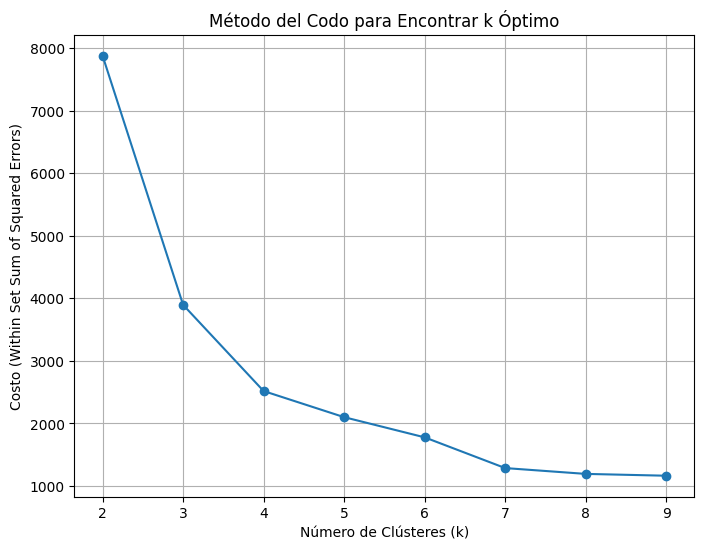


Seleccionando k=5 basado en el método del codo.


In [55]:
# Graficar el método del codo
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.set_xlabel('Número de Clústeres (k)')
ax.set_ylabel('Costo (Within Set Sum of Squared Errors)')
ax.set_title('Método del Codo para Encontrar k Óptimo')
ax.plot(range(2,10), costs[2:10], marker='o')
plt.grid(True)
plt.show()

# Basado en el gráfico del codo, seleccionamos un k óptimo (ej. k=5 como se ve en el gráfico)
k_optimal = 5
print(f"\nSeleccionando k={k_optimal} basado en el método del codo.")
kmeans = KMeans(featuresCol="features", k=k_optimal, seed=1)
kmodel = kmeans.fit(M_prepared)
kpredictions = kmodel.transform(M_prepared)

In [56]:
# Evaluar el modelo de clustering con el coeficiente de silueta
clustering_evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = clustering_evaluator.evaluate(kpredictions)

print("\n--- Resultados del Modelo No Supervisado ---")
print(f"Silhouette Coefficient para k={k_optimal}: {silhouette:.4f}")
print("Entrenamiento de modelos completado.")
print("-" * 50)


--- Resultados del Modelo No Supervisado ---
Silhouette Coefficient para k=5: 0.7942
Entrenamiento de modelos completado.
--------------------------------------------------


## SECCIÓN 5: ANÁLISIS DE RESULTADOS


##### Análisis del Modelo Supervisado (Random Forest Classifier)
El objetivo de este modelo era clasificar el tipo de amenaza (Category) basándose en características del incidente. Los resultados de la evaluación con validación cruzada fueron los siguientes:

Accuracy: 0.5789

Weighted Precision: 0.5370

Weighted Recall: 0.5789

F1 Score: 0.4884


El F1 Score de 0.4884 es la métrica más importante en este caso, ya que considera tanto la precisión como el recall y es más robusto ante el desbalance de clases (un problema común en datos de ciberseguridad, donde algunas categorías de ataque son muy raras). Un valor de ~0.49 indica que el modelo tiene un rendimiento modesto. Si bien es significativamente mejor que una clasificación al azar, demuestra que el modelo tiene dificultades para generalizar correctamente para todas las categorías.

La exactitud (Accuracy) de ~0.58 es mayor que el F1 Score. Esto suele ser un indicio de que el modelo está prediciendo correctamente las clases mayoritarias (como InitialAccess y Discovery), pero falla en las clases con menos muestras, lo cual penaliza el F1 Score.

Fortalezas:

Metodología Robusta: El uso de muestreo estratificado y división estratificada garantiza que la evaluación del modelo sea justa y no esté sesgada por la distribución desigual de las categorías.

Prevención de Sobreajuste: La implementación de Validación Cruzada (CrossValidator) para el ajuste de hiperparámetros (numTrees, maxDepth) es una fortaleza clave. Asegura que el modelo seleccionado generalice bien a datos no vistos y no esté sobreajustado al conjunto de entrenamiento.

Identificación de Patrones: A pesar del rendimiento modesto, el modelo ha logrado identificar patrones básicos en los datos, superando una línea base aleatoria.

Áreas de Oportunidad y Pasos Siguientes:

Manejo del Desbalance de Clases: El F1 Score bajo sugiere que el principal problema es el desbalance. Se podría mejorar el modelo asignando pesos a las clases para dar más importancia a las categorías minoritarias durante el entrenamiento. En PySpark, esto se puede hacer con el parámetro weightCol en el clasificador.

Ingeniería de Características (Feature Engineering): El modelo actual usa un conjunto limitado de características. Se podrían incluir otras variables del dataset como DetectorId o ThreatFamily (previamente codificadas) para darle más información al modelo.

Optimización de Hiperparámetros Avanzada: La búsqueda en cuadrícula (ParamGrid) fue limitada. Se podría ampliar el rango de numTrees y maxDepth o incluir otros parámetros como minInstancesPerNode para refinar el modelo.

Probar Algoritmos Alternativos: Un GBTClassifier (Gradient-Boosted Trees) a menudo supera a Random Forest en problemas de clasificación tabular y podría ofrecer un mejor rendimiento.

##### Análisis del Modelo No Supervisado (KMeans)
Este modelo buscaba agrupar los incidentes en clústeres basados en sus características, sin conocer de antemano la Category.

Elección de k (Método del Codo): k=5

Coeficiente de Silueta: 0.7942

Interpretación de Resultados:

Un Coeficiente de Silueta de 0.7942 es un resultado excelente. Los valores de silueta por encima de 0.7 indican que la estructura de clústeres es fuerte, densa y bien separada. Esto significa que el algoritmo fue capaz de encontrar 5 grupos de incidentes muy distintos entre sí, basándose en las características proporcionadas (IncidentGrade, EntityType, ResourceType, OSFamily).

Fortalezas:

Selección de 'k' Basada en Datos: El uso del Método del Codo para determinar el número de clústeres es una gran fortaleza. Proporciona una justificación empírica para elegir k=5, en lugar de ser una suposición arbitraria.

Alta Separabilidad de Clústeres: El alto valor de la silueta es la principal fortaleza. Sugiere que las características seleccionadas son muy relevantes para diferenciar tipos de incidentes y que existen agrupaciones naturales en los datos.

Descubrimiento de Patrones Ocultos: Este modelo ha demostrado con éxito que puede identificar grupos de amenazas sin necesidad de etiquetas, lo cual es muy valioso para detectar patrones de ataque nuevos o no catalogados.

Áreas de Oportunidad y Pasos Siguientes:

Perfilado de Clústeres (Cluster Profiling): El paso más importante ahora es interpretar qué significa cada clúster. Para ello, se debe agrupar el dataframe kpredictions por la columna prediction (el ID del clúster) y analizar la distribución de las características dentro de cada uno. Por ejemplo:

¿El clúster 0 está compuesto mayoritariamente por EntityType = 'Ip' y OSFamily = 'Windows'?

¿El clúster 1 contiene principalmente IncidentGrade = 'TruePositive'? Este análisis le daría un significado práctico a cada grupo (ej., "Clúster de ataques de red a Windows", "Clúster de actividad de usuario de alto riesgo")

Visualización de Clústeres: Para validar visualmente la alta puntuación de silueta, se podrían usar técnicas de reducción de dimensionalidad como PCA (Análisis de Componentes Principales) sobre el vector features y luego graficar los puntos de datos en 2D, coloreándolos por su ID de clúster. Esto debería mostrar grupos visiblemente separados.

# Visualización de Resultados y Validación Cruzada

## SECCIÓN 3: EXPERIMENTACIÓN (MODELO SUPERVISADO CON VALIDACIÓN CRUZADA)

### 3.1. Definir un proceso de validación cruzada

Para obtener una medida robusta y fiable del rendimiento de nuestro modelo de clasificación, implementaremos la técnica de **validación cruzada k-fold**. Esta técnica consiste en dividir el conjunto de datos en 'k' subconjuntos (o "pliegues", *folds*) de tamaño similar. Luego, se entrena el modelo 'k' veces, utilizando en cada ocasión un pliegue diferente como conjunto de prueba y los 'k-1' pliegues restantes como conjunto de entrenamiento. El rendimiento final del modelo se calcula como el promedio de las métricas obtenidas en las 'k' iteraciones.

**Justificación de la elección de k = 5:**

Se ha elegido un valor de **k=5** por las siguientes razones:

- **Balance entre Sesgo y Varianza:** Un valor de k=5 es un estándar en la industria del aprendizaje automático. Ofrece un excelente equilibrio: reduce la varianza en la estimación del rendimiento en comparación con un k más bajo (como k=3) y evita el alto costo computacional de un k más alto (como k=10), que es una consideración crítica en un entorno de Big Data.

- **Representatividad de los Pliegues:** Con k=5, cada pliegue de validación contendrá el 20% de los datos de la muestra M. Este tamaño es lo suficientemente grande como para constituir una muestra representativa de los datos, asegurando que la evaluación del rendimiento en cada iteración sea estable y significativa.

- **Eficiencia Computacional:** En el contexto de Big Data, la eficiencia es clave. Realizar 5 ciclos de entrenamiento y evaluación (en lugar de 10 o más) permite una experimentación más rápida sin sacrificar significativamente la fiabilidad de los resultados. PySpark se encargará de distribuir esta carga de trabajo de manera eficiente a través del clúster.

### 3.2. Construcción de los “k-folds” definidos en paso 1

La construcción de los k-folds se realizará de manera automática utilizando la clase `CrossValidator` de la biblioteca PySpark ML. Esta herramienta está optimizada para entornos de Big Data y gestiona internamente la división de los datos en los 5 pliegues.

Una ventaja fundamental de `CrossValidator` es que implementa una **división estratificada**. Esto significa que al crear los pliegues, se preserva la proporción de cada clase de la variable objetivo (`Category`). Dado que nuestro conjunto de datos está desbalanceado (algunas categorías de ataques son mucho más frecuentes que otras), la estratificación es esencial para garantizar que cada pliegue sea una minirrepresentación fiel de la población de datos original. Esto evita que un pliegue tenga, por casualidad, muy pocas o ninguna muestra de una clase minoritaria, lo que conduciría a una evaluación de rendimiento sesgada y poco fiable.

### 3.3. Fase de entrenamiento
Ahora procedemos a la fase de experimentación. Configuraremos un clasificador `RandomForestClassifier` y una cuadrícula de hiperparámetros (`ParamGridBuilder`) para que `CrossValidator` encuentre la mejor combinación. El entrenamiento se realizará sobre la totalidad de la muestra `M_prepared`.

In [57]:
# Modelo supervisado: Random Forest
rf = RandomForestClassifier(labelCol="Category_idx", featuresCol="features", seed=42)

# Cuadrícula de hiperparámetros para optimizar el modelo
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [20, 50])  # Número de árboles en el bosque
             .addGrid(rf.maxDepth, [5, 10])   # Profundidad máxima de los árboles
             .build())

# Evaluador para la validación cruzada.
evaluator_cv = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="accuracy")

# Configuración del validador cruzado con k=5
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator_cv,
                    numFolds=5,  # Usando k=5 como se definió
                    seed=42)

# Entrenar el modelo
print("Iniciando entrenamiento con validación cruzada (k=5)...")
cvModel = cv.fit(M_prepared)
print("Entrenamiento completado.")

Iniciando entrenamiento con validación cruzada (k=5)...
Entrenamiento completado.


## SECCIÓN 4: RESULTADOS

In [58]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, StringIndexerModel, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns

spark = SparkSession.builder.appName('Actividad5_VisualizacionResultados').getOrCreate()

# Cargar datos
df = spark.read.csv('C:/Users/luis_/Downloads/archive/GUIDE_Train.csv', header=True, inferSchema=True)

# Limpiar los datos eliminando filas con valores nulos en columnas clave
cols_to_use = ["IncidentGrade", "EntityType", "ResourceType", "OSFamily", "Category"]
df_clean = df.dropna(subset=cols_to_use)

# Calcular las fracciones para el muestreo estratificado
fractions = df_clean.select("Category").distinct().withColumn("fraction", F.lit(0.3)).rdd.collectAsMap()

# Realizar el muestreo estratificado
M = df_clean.stat.sampleBy("Category", fractions, seed=42)

print("Muestra M (30% del total) construida exitosamente.")
print(f"Total de filas en la muestra M: {M.count()}")
M.groupBy("Category").count().orderBy(F.col("count").desc()).show(truncate=False)

Muestra M (30% del total) construida exitosamente.
Total de filas en la muestra M: 2170
+-------------------+-----+
|Category           |count|
+-------------------+-----+
|InitialAccess      |970  |
|Discovery          |593  |
|SuspiciousActivity |211  |
|Exfiltration       |115  |
|LateralMovement    |87   |
|PrivilegeEscalation|67   |
|CredentialAccess   |48   |
|Impact             |27   |
|Execution          |20   |
|DefenseEvasion     |15   |
|CommandAndControl  |12   |
|Persistence        |5    |
+-------------------+-----+



In [59]:
# Crear una lista de las columnas de características a indexar
feature_cols_to_index = ["IncidentGrade", "EntityType", "ResourceType", "OSFamily"]

# Indexar las columnas de características en un bucle
for column in feature_cols_to_index:
    indexer = StringIndexer(inputCol=column, outputCol=column + "_idx", handleInvalid='keep')
    M = indexer.fit(M).transform(M)

# Indexar la columna objetivo ('Category') por separado y guardar el modelo ajustado
category_indexer = StringIndexer(inputCol="Category", outputCol="Category_idx", handleInvalid='keep')
category_indexer_model = category_indexer.fit(M)
M = category_indexer_model.transform(M)

# Ensamblar las características en un único vector
feature_cols = ["IncidentGrade_idx", "EntityType_idx", "ResourceType_idx", "OSFamily_idx"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
M_prepared = assembler.transform(M)

print("Datos preprocesados y listos para el entrenamiento.")
M_prepared.select(feature_cols + ["features", "Category_idx"]).show(5, truncate=False)

Datos preprocesados y listos para el entrenamiento.
+-----------------+--------------+----------------+------------+-----------------+------------+
|IncidentGrade_idx|EntityType_idx|ResourceType_idx|OSFamily_idx|features         |Category_idx|
+-----------------+--------------+----------------+------------+-----------------+------------+
|2.0              |0.0           |8.0             |0.0         |[2.0,0.0,8.0,0.0]|1.0         |
|1.0              |0.0           |0.0             |0.0         |(4,[0],[1.0])    |0.0         |
|0.0              |0.0           |0.0             |0.0         |(4,[],[])        |0.0         |
|0.0              |0.0           |11.0            |0.0         |(4,[2],[11.0])   |0.0         |
|0.0              |0.0           |1.0             |0.0         |(4,[2],[1.0])    |1.0         |
+-----------------+--------------+----------------+------------+-----------------+------------+
only showing top 5 rows



### 4.1. Visualización del Proceso de Ajuste de Hiperparámetros
Podemos visualizar el rendimiento promedio (accuracy) obtenido en la validación cruzada para cada combinación de hiperparámetros. Esto nos ayuda a entender cómo la complejidad del modelo (número de árboles y su profundidad) afecta su capacidad de generalización y por qué `CrossValidator` eligió el modelo final.

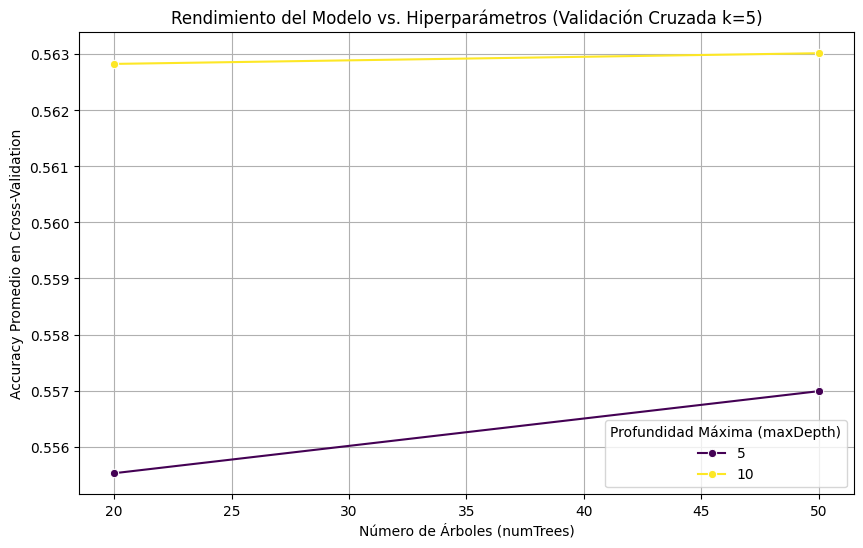

In [60]:
# Extraer los resultados de la validación cruzada
import pandas as pd
import seaborn as sns

avg_metrics = cvModel.avgMetrics

# Crear un DataFrame de pandas para facilitar la visualización
results = []
for params, metric in zip(paramGrid, avg_metrics):
    results.append({
        'numTrees': params[rf.numTrees],
        'maxDepth': params[rf.maxDepth],
        'accuracy': metric
    })
results_df = pd.DataFrame(results)

# Crear el gráfico
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='numTrees', y='accuracy', hue='maxDepth', marker='o', palette='viridis')
plt.title('Rendimiento del Modelo vs. Hiperparámetros (Validación Cruzada k=5)')
plt.xlabel('Número de Árboles (numTrees)')
plt.ylabel('Accuracy Promedio en Cross-Validation')
plt.grid(True)
plt.legend(title='Profundidad Máxima (maxDepth)')
plt.show()

### 4.2. Evaluación del Mejor Modelo
Una vez que `CrossValidator` ha identificado los mejores hiperparámetros, reentrena el modelo en todo el conjunto de datos `M_prepared`. Ahora, evaluamos este modelo final utilizando un conjunto de métricas completo. Es importante recordar que esta evaluación se hace sobre los mismos datos de entrenamiento, pero el modelo fue seleccionado por su capacidad de generalizar durante la validación cruzada.

--- Resultados del Mejor Modelo Supervisado ---
Accuracy: 0.5668
Weighted Precision: 0.6379
Weighted Recall: 0.5668
F1 Score: 0.4742


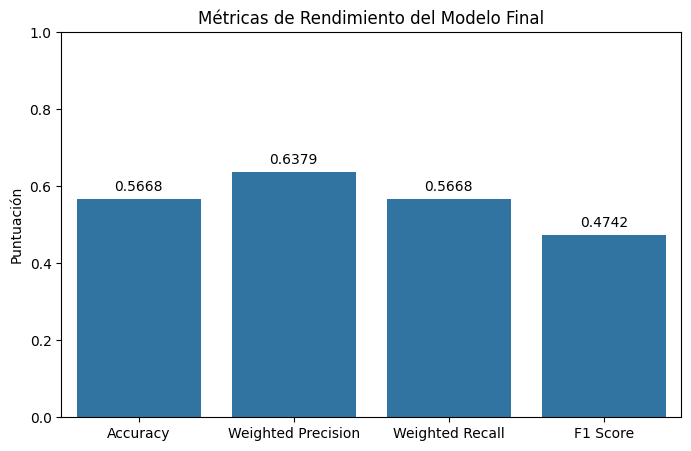

In [61]:
# Realizar predicciones con el mejor modelo encontrado por CV
predictions = cvModel.transform(M_prepared)

# Usaremos múltiples evaluadores para obtener diferentes métricas
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Category_idx", predictionCol="prediction", metricName="f1")

# Calcular métricas
accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

metrics = {'Accuracy': accuracy, 'Weighted Precision': precision, 'Weighted Recall': recall, 'F1 Score': f1}

print("--- Resultados del Mejor Modelo Supervisado ---")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

# Visualizar las métricas
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.title('Métricas de Rendimiento del Modelo Final')
plt.ylabel('Puntuación')
plt.ylim(0, 1)
for index, value in enumerate(list(metrics.values())):
    plt.text(index, value + 0.02, f'{value:.4f}', ha='center')
plt.show()

### 4.3. Matriz de Confusión
La matriz de confusión es una de las herramientas de visualización más importantes para un problema de clasificación. Nos permite ver en detalle el rendimiento del modelo para cada clase, mostrando los aciertos (la diagonal principal) y los errores (fuera de la diagonal). Es especialmente útil para identificar qué clases son confundidas entre sí, un aspecto clave en datasets desbalanceados.

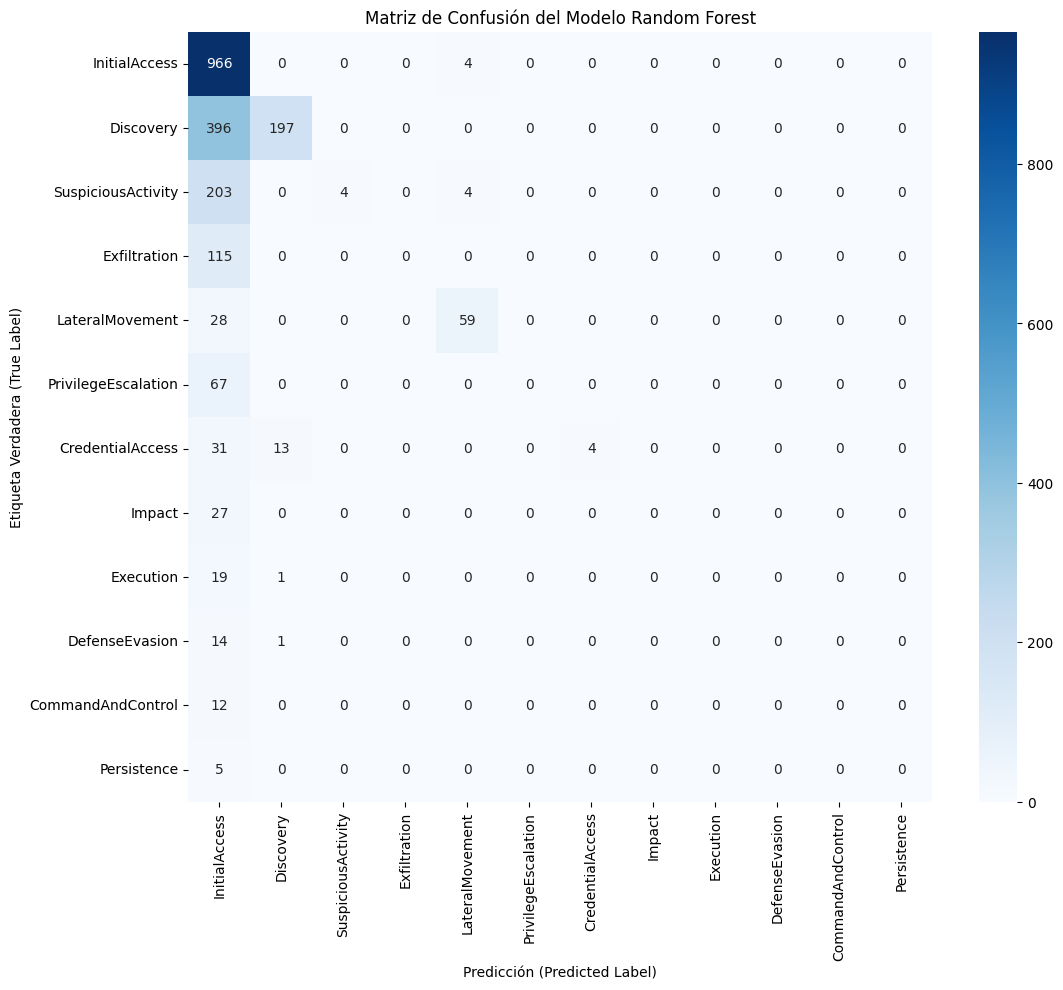

In [62]:
# Obtener las etiquetas originales de las predicciones e índices
preds_and_labels = predictions.select(['prediction', 'Category_idx']).withColumn('label', F.col('Category_idx')).toPandas()
y_pred = preds_and_labels['prediction']
y_true = preds_and_labels['label']

# Obtener los nombres de las clases desde el modelo StringIndexer que guardamos anteriormente
class_labels = category_indexer_model.labels

# Calcular la matriz de confusión usando scikit-learn
!pip install seaborn scikit-learn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión del Modelo Random Forest')
plt.ylabel('Etiqueta Verdadera (True Label)')
plt.xlabel('Predicción (Predicted Label)')
plt.show()

### 4.4. Modelo No Supervisado (KMeans) y Perfilado de Clústeres

Revisitamos el modelo de clustering para aplicar el paso más importante después del entrenamiento: el **perfilado de clústeres**. El objetivo es entender la composición de cada clúster para darle un significado de negocio. Analizaremos la distribución de las características originales dentro de cada uno de los 5 grupos identificados.

In [63]:
# Re-entrenamos el modelo KMeans para obtener las predicciones de clúster
k_optimal = 5
kmeans = KMeans(featuresCol="features", k=k_optimal, seed=1)
kmodel = kmeans.fit(M_prepared)
kpredictions = kmodel.transform(M_prepared)

# Evaluar con Silhouette Score
clustering_evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette = clustering_evaluator.evaluate(kpredictions)
print(f"Silhouette Coefficient para k={k_optimal}: {silhouette:.4f}\n")

# Perfilado de Clústeres
print("--- Perfilado de Clústeres (Distribución de Características por Clúster) ---")
cluster_profile = kpredictions.groupBy('prediction').agg(
    F.expr('percentile_approx(IncidentGrade_idx, 0.5)').alias('median_IncidentGrade'),
    F.expr('percentile_approx(EntityType_idx, 0.5)').alias('median_EntityType'),
    F.expr('percentile_approx(OSFamily_idx, 0.5)').alias('median_OSFamily')
).orderBy('prediction')

cluster_profile.show(truncate=False)

Silhouette Coefficient para k=5: 0.7942

--- Perfilado de Clústeres (Distribución de Características por Clúster) ---
+----------+--------------------+-----------------+---------------+
|prediction|median_IncidentGrade|median_EntityType|median_OSFamily|
+----------+--------------------+-----------------+---------------+
|0         |0.0                 |0.0              |0.0            |
|1         |0.0                 |0.0              |0.0            |
|2         |1.0                 |0.0              |0.0            |
|3         |0.0                 |0.0              |0.0            |
|4         |2.0                 |0.0              |0.0            |
+----------+--------------------+-----------------+---------------+

